In [60]:
#%%capture 
#%run 0DataPreprocessing.ipynb

In [61]:
#allflights = getData()

In [62]:
from pyspark.sql.functions import *       # added for the function 
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import FloatType

spark = SparkSession.builder \
    .master('local') \
    .appName('CancelledFlights') \
    .getOrCreate()

# Functions to add a 0 to days/months to make dates sortable
def formatDecimal(n):
    if len(n) == 1:
        return '0' + n
    else: 
        return n
    
def formatDate(n):
    n = n.split('-')
    return n[0]+'-'+formatDecimal(n[1])+'-'+formatDecimal(n[2])

allflights = spark.read.load("./data/alldata.csv",format="csv", sep=",", header="true")

df = allflights.select(concat(col("Year"), lit("-"), col("Month"), lit("-"), col("DayofMonth")).alias('Date'), 'Cancelled')
df = df.where(col("Date").isNotNull() & col("Cancelled").isNotNull())
df = df.filter((df['Date'] != 'Year-Month-DayofMonth'))

#df.show()

## Statistics of total flights 
totalFlights   = float(df.count())
#print(totalFlights)
totalCancelled = float(df.filter(df['Cancelled'] == 1).count())
#print(totalCancelled)
totalPercentageCancelled = totalCancelled / totalFlights
#print(totalPercentageCancelled)

## Group all flights by date
fc = df.groupBy("Date").count().selectExpr("Date as d", "count as flights")
fc = fc.withColumn("flights", fc["flights"].cast(FloatType()))
#fc.show()
## Group all canceled flight by date 
cfc = df.filter(df['Cancelled'] == 1).groupBy("Date").count().selectExpr("Date as d1", "count as cflights")
cfc = cfc.withColumn("cflights", cfc["cflights"].cast(FloatType()))
#cfc.show()
## Join the two tables to have each row contain the total and total canceled flights
cpd = fc.join(cfc, fc.d == cfc.d1, how='left').drop('d1').na.fill(0)
#cpd.show()

In [63]:
## Calculate the percentage 
percentage = cpd.rdd.map(lambda x: (x[0], (x[2]/x[1])*100)) \
       .map(lambda x: (formatDate(x[0]), x[1])) \
       .sortByKey().toDF()
percentage = percentage.select(col("_1").alias("Date"), col("_2").alias("Percentage"))
#percentage.show()       

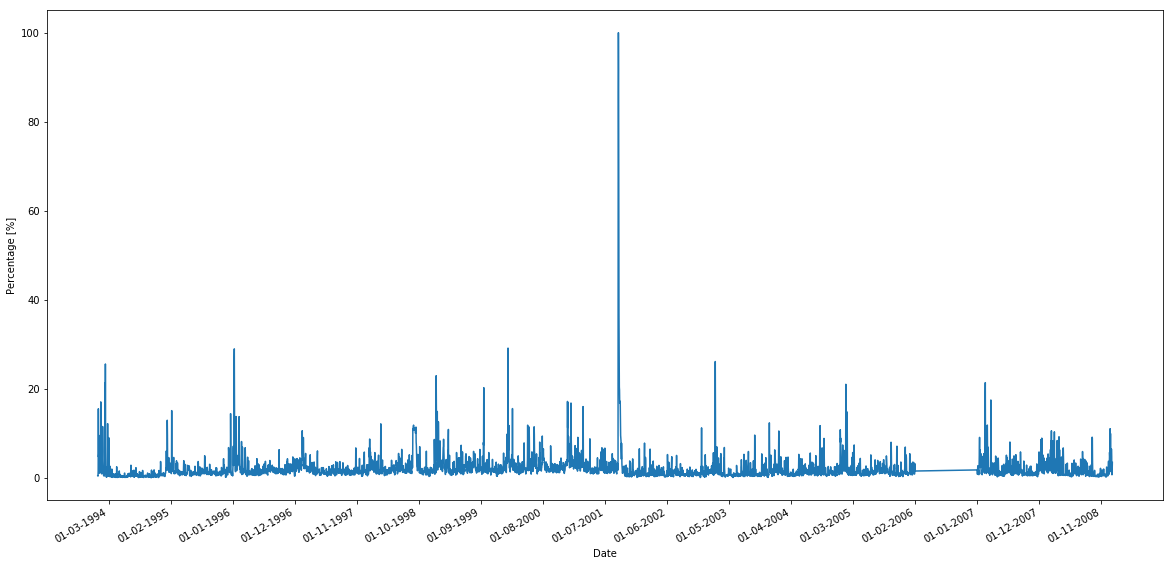

Text(0,0.5,'Percentage [%]')

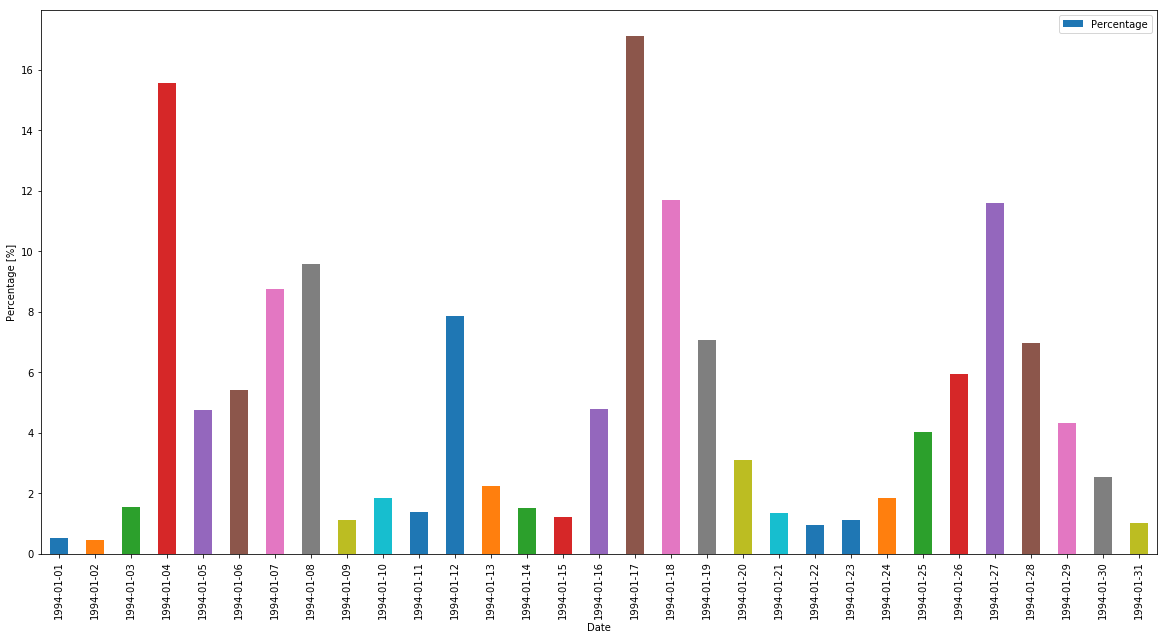

In [64]:
## Visualize the percentage for all data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Process dataset
pdf['Date'] = pd.to_datetime(pdf['Date'])
pdf['Percentage'] = pd.to_numeric(pdf['Percentage'])

# Plot
plt.figure(figsize=(20, 10))
plt.plot(pdf['Date'], pdf['Percentage'])
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=11))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
ax.set_xlabel('Date')
ax.set_ylabel('Percentage [%]')
plt.gcf().autofmt_xdate() # Rotation
plt.show()

## Visualize the percentage for first month
import matplotlib
import matplotlib.pyplot as plt

pdf = percentage.toPandas()
ax2 = pdf.head(31).plot.bar(x='Date', y='Percentage', figsize=(20, 10))
ax2.set_xlabel("Date")
ax2.set_ylabel("Percentage [%]")

In [65]:
## Statistics 
highest = pdf.loc[pdf['Percentage'].idxmax()] # Day with highest cancellations
#print(highest)
lowest = pdf.loc[pdf['Percentage'].idxmin()]  # Day with lowest cancellations
#print(lowest)
summary = percentage.describe('Percentage')

In [66]:
## Give summary of statistics
print('Flights cancelled / Total flights:   %d / %d \n' % (totalCancelled, totalFlights))
print('Percentage of cancelled flight   :   %.2f%%' % (totalPercentageCancelled*100))

print('\nDay with highest cancellations : %s with %.2f%%' % (highest[0], highest[1]))
print('Day with lowest cancellations  : %s with %.2f%%\n' % (lowest[0], lowest[1]))
summary.show()

Flights cancelled / Total flights:   1832448 / 84533169 

Percentage of cancelled flight   :   2.17%

Day with highest cancellations : 2001-09-12 with 99.99%
Day with lowest cancellations  : 1994-10-16 with 0.06%

+-------+-------------------+
|summary|         Percentage|
+-------+-------------------+
|  count|               5145|
|   mean|  2.156759074735758|
| stddev|  3.279749859104091|
|    min|0.06376647300552643|
|    max|  99.99429744525547|
+-------+-------------------+

